# KNN Model for predicting raquette type

Import

In [2]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile, loadmat
from scipy.signal import hilbert
from scipy.fft import fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import openpyxl


sr = 20000


Readwav function

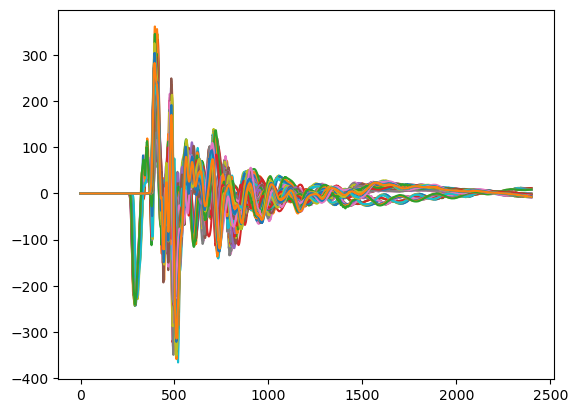

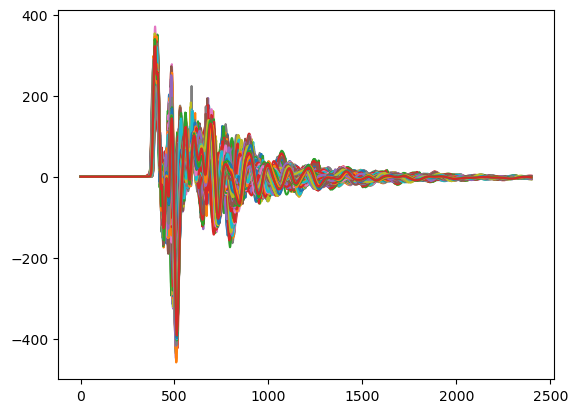

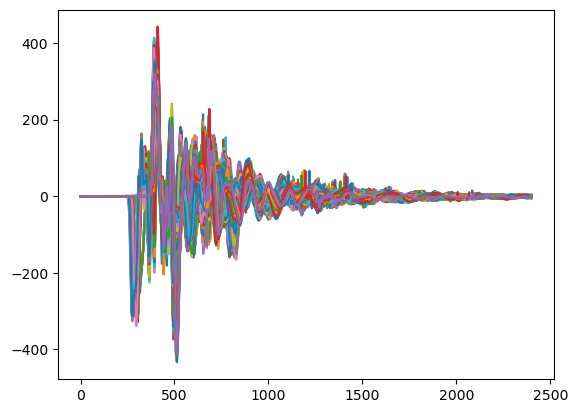

In [3]:
def readCsvFolder(folderPath):
    fileFolder = []
    fileNames = []
    for dirpath, dirs, files in os.walk(folderPath):
        for file in files:
            if file.endswith('.csv') and "_C_" in file:
                base_name = os.path.splitext(file)[0]
                file_path = os.path.join(dirpath, file)  # Full path of the file
                data = pd.read_csv(file_path)  # Read the CSV file using pandas
                fileFolder.append(data)
                fileNames.append(file)  # Store the file name
    return fileFolder, fileNames

p1_csv_vect, p1_files = readCsvFolder("../Vibrations/P1_clean")
p2_csv_vect, p2_files = readCsvFolder("../Vibrations/P2_clean")
p3_csv_vect, p3_files = readCsvFolder("../Vibrations/P3_clean")



for i in range(len(p1_csv_vect)):
    plt.plot(p1_csv_vect[i].iloc[:, 0])  # Plot only the first column
plt.show()

for i in range(len(p2_csv_vect)):
    plt.plot(p2_csv_vect[i].iloc[:, 0])  # Plot only the first column
plt.show()

for i in range(len(p3_csv_vect)):
    plt.plot(p3_csv_vect[i].iloc[:, 0])  # Plot only the first column
plt.show()

Spectrum

72 324 255


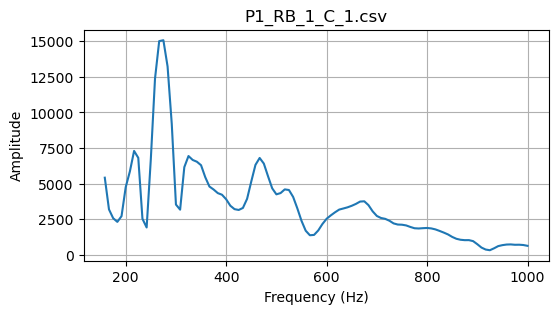

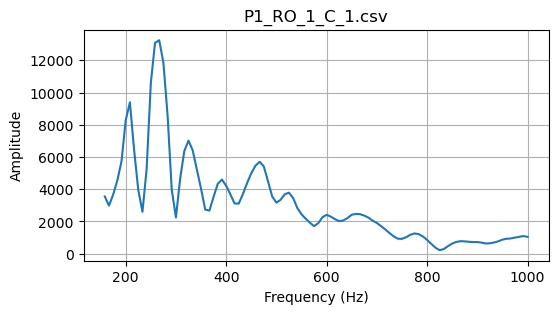

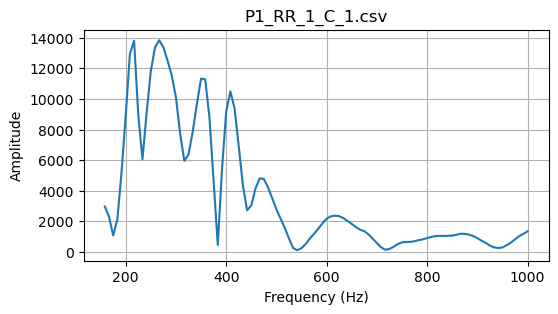

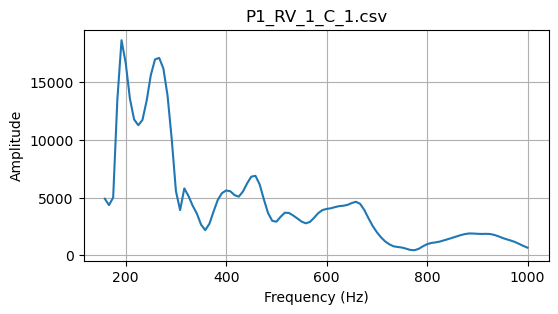

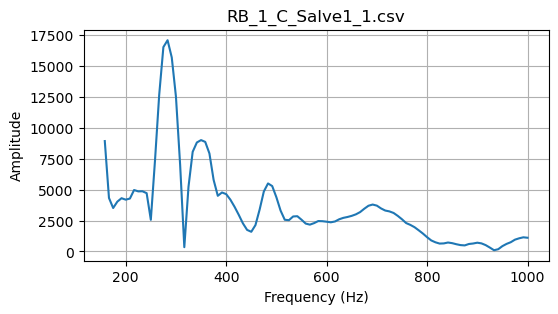

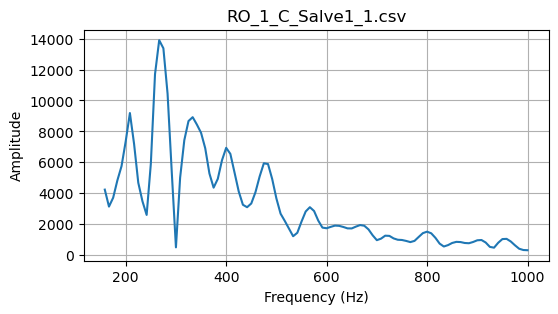

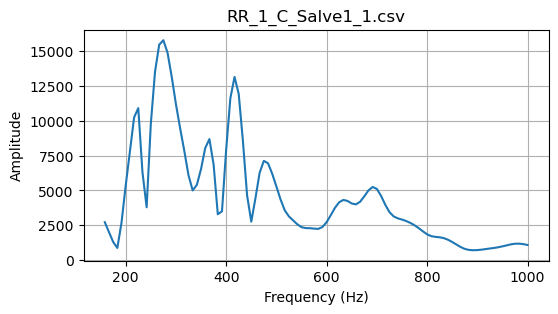

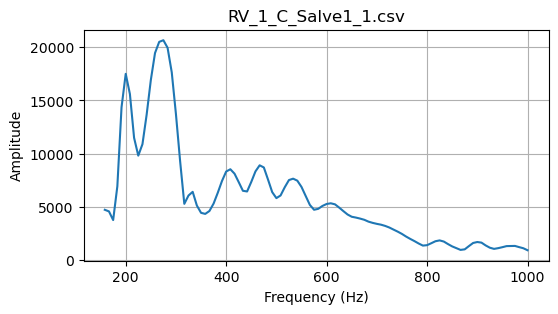

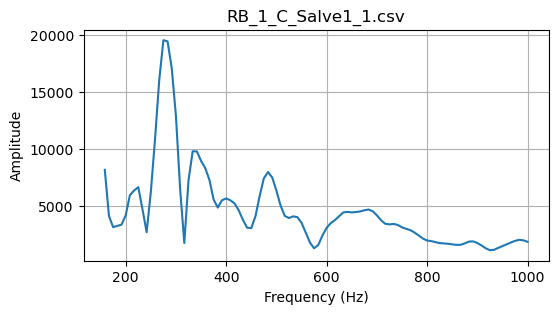

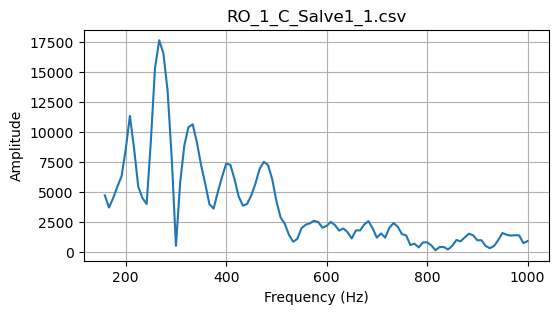

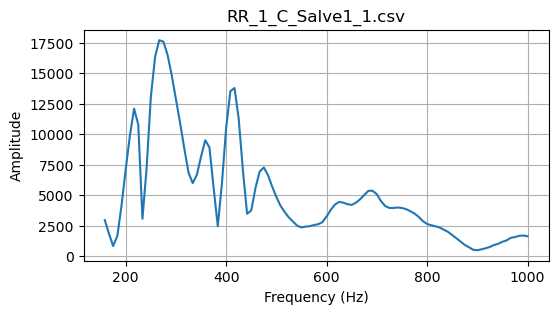

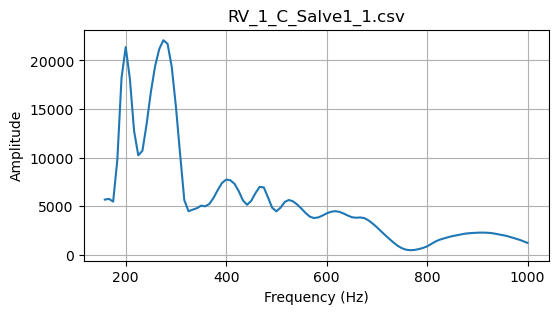

In [4]:
def spectrumFromCsv(channel, sampling_rate=sr):
    signal = channel.iloc[:, 0].values  # vibration data
    N = len(signal)
    xf = np.fft.fftfreq(N, d=1/sampling_rate)[:N // 2]
    spectrum = fft(signal)
    magnitude = abs(spectrum[:N // 2])
    return xf, magnitude

# Data sources
file_groups = [p1_files, p2_files, p3_files]
csv_groups = [p1_csv_vect, p2_csv_vect, p3_csv_vect]
spectrum_groups = [[], [], []]  # Will hold p1_spectrum_vect, p2_spectrum_vect, p3_spectrum_vect

# Step 1: Compute and store filtered spectra for all groups
for group_idx in range(len(file_groups)):
    for i in range(len(file_groups[group_idx])):
        freqs, spectrum = spectrumFromCsv(csv_groups[group_idx][i])
        band_mask = (freqs >= 150) & (freqs <= 1000)
        filtered_freqs = freqs[band_mask]
        filtered_spectrum = spectrum[band_mask]
        spectrum_groups[group_idx].append((filtered_freqs, filtered_spectrum))

# Optional: Print lengths for verification
print(len(spectrum_groups[0]), len(spectrum_groups[1]), len(spectrum_groups[2]))

# Step 2: Plot one sample per racket type from each group
for group_idx in range(len(file_groups)):
    spectrum_vect = spectrum_groups[group_idx]
    files = file_groups[group_idx]
    shown_raquettes = {"RB": 0, "RO": 0, "RR": 0, "RV": 0}

    for i, (freqs, spectrum) in enumerate(spectrum_vect):
        for raquetteType in shown_raquettes:
            if raquetteType in files[i] and shown_raquettes[raquetteType] == 0:
                plt.figure(figsize=(6, 3))
                plt.plot(freqs, spectrum)
                plt.grid()
                plt.title(f"{files[i]}")
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Amplitude")
                plt.show()
                shown_raquettes[raquetteType] = 1



# Peaks

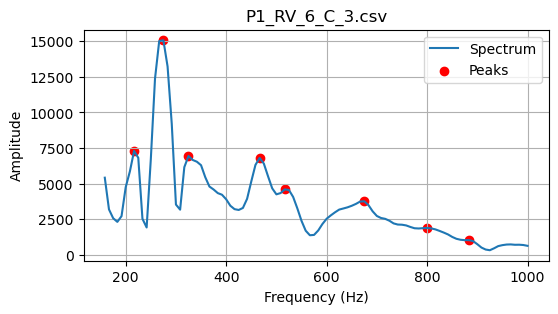

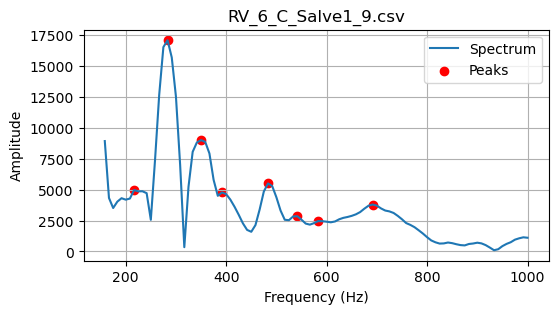

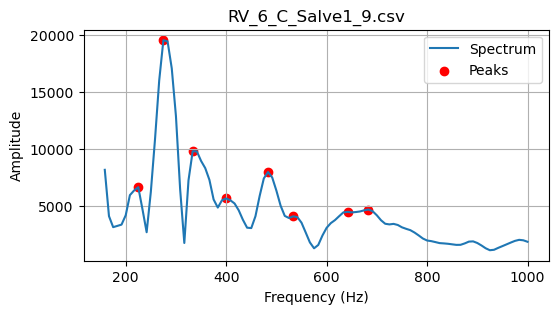

In [5]:
def extractNPeak(n_peak, signal_tuple):
    freqs, spectrum = signal_tuple

    peaks, _ = find_peaks(spectrum, distance=5)
    sorted_indices = np.argsort(spectrum[peaks])[::-1][:n_peak]
    peaks = peaks[sorted_indices]

    peak_frequencies = freqs[peaks]
    peak_values = spectrum[peaks]   

    return peak_frequencies, peak_values

peak_groups = [[],[],[]]
for group_idx in range(len(file_groups)):
    files = file_groups[group_idx]
    spectrum_vect = spectrum_groups[group_idx]

    # Limit to just the first sample from each group
    for i, (freqs, spectrum) in enumerate(spectrum_vect):
        peak_freq, peak_val = extractNPeak(8, (freqs, spectrum))
        peak_groups[group_idx].append((peak_freq, peak_val))
    peaks, peak_values = peak_groups[group_idx][0]
    plt.figure(figsize=(6, 3))
    plt.plot(spectrum_vect[0][0], spectrum_vect[0][1], label="Spectrum")
    plt.scatter(peaks, peak_values, color='red', label="Peaks")
    plt.title(files[i])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.show()

## Envelope

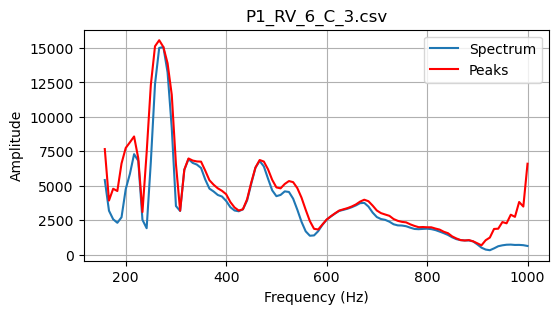

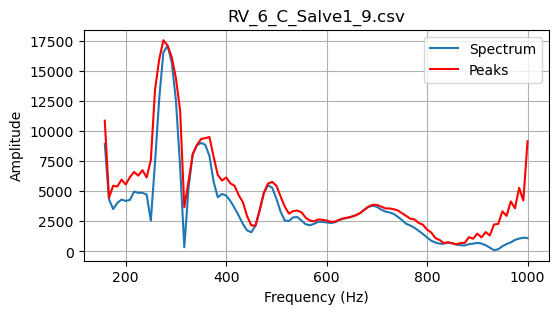

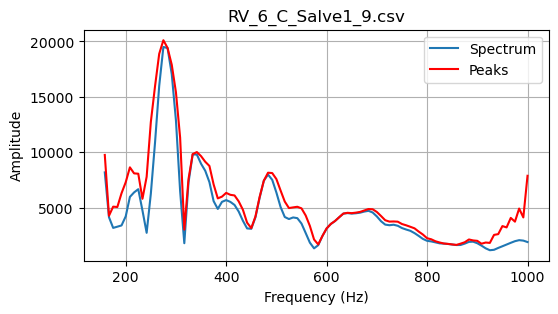

In [6]:
def envelope(signal_tuple, fs=sr):
    freqs, spectrum = signal_tuple
    analytic_signal = hilbert(spectrum)
    amplitude_envelope = np.abs(analytic_signal)
    return freqs, amplitude_envelope

envelope_groups = [[],[],[]]
for group_idx in range(len(file_groups)):
    files = file_groups[group_idx]
    spectrum_vect = spectrum_groups[group_idx]

    # Limit to just the first sample from each group
    for i, (freqs, spectrum) in enumerate(spectrum_vect):
        freq, val = envelope((freqs, spectrum))
        envelope_groups[group_idx].append((freq, val))
    freqs, vals = envelope_groups[group_idx][0]
    plt.figure(figsize=(6, 3))
    plt.plot(spectrum_vect[0][0], spectrum_vect[0][1], label="Spectrum")
    plt.plot(freqs, vals, color='red', label="Peaks")
    plt.title(files[i])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.show()

## energy per band


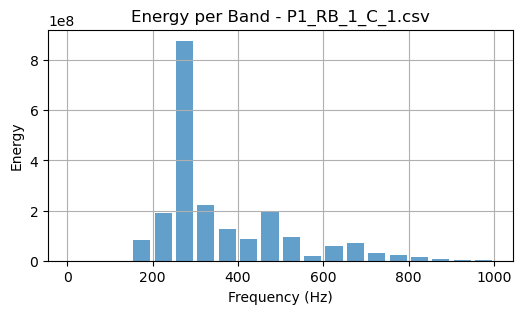

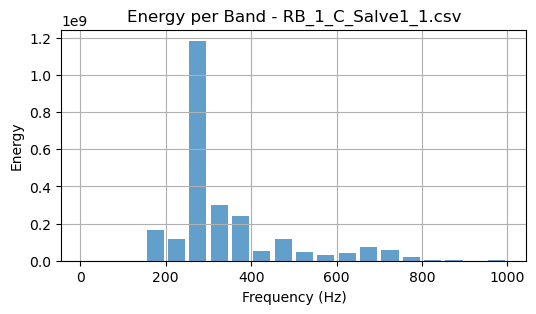

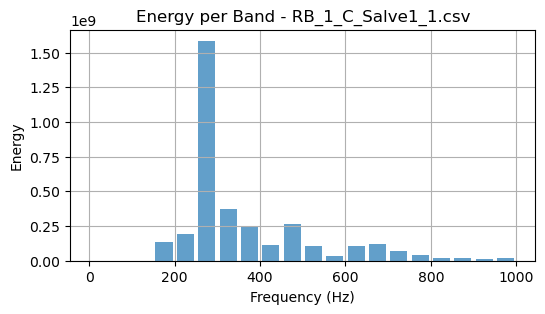

In [7]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

band_width = 50  # Band width in Hz
energy_groups = [[], [], []]
for group_idx in range(len(file_groups)):
    files = file_groups[group_idx]
    spectrum_vect = spectrum_groups[group_idx]

    # Calculate energy per band for each spectrum
    for i, (freqs, spectrum) in enumerate(spectrum_vect):
        band_energies, band_frequencies = energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width)
        energy_groups[group_idx].append((band_frequencies, band_energies))

    # Plot energy per band for the first sample in the group
    band_freqs, band_energies = energy_groups[group_idx][0]
    plt.figure(figsize=(6, 3))
    plt.bar(band_freqs, band_energies, width=band_width * 0.8, align='center', alpha=0.7)
    plt.title(f"Energy per Band - {files[0]}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Energy")
    plt.grid()
    plt.show()


## mfcc's

In [8]:
import librosa

def mfccs_from_csv(channel, sr=sr, n_mfcc=13):
    signal = channel.iloc[:, 0].values  # vibration data
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return mfccs

mfccs = mfccs_from_csv(p1_csv_vect[0])
print(mfccs)

[[ 3.39729176e+02  4.07940260e+02  3.54279094e+02  1.64302832e+02
   1.24666391e+02]
 [ 2.00286314e+02  1.90024357e+02  1.75643611e+02  1.31737900e+02
   1.10999766e+02]
 [ 7.50403344e+01  7.02225085e+01  6.78321254e+01  6.56976868e+01
   3.23051902e+01]
 [-1.62541200e+01 -6.94791603e+00  7.27169194e+00  4.75100938e+01
   3.09731480e+01]
 [ 4.36054439e+00  1.77158539e+00  4.38911064e+00  4.28223166e+01
   2.48956260e+01]
 [ 2.65220290e+00 -4.17802614e-01 -3.31180011e+00  1.05489715e+01
   2.00822522e+01]
 [ 8.73099202e+00  4.79408884e+00  1.76185259e+00  8.69133752e+00
   1.69953591e+01]
 [-6.38415699e+00 -8.19042331e+00 -7.46531696e+00  1.45178197e+00
   1.55300904e+01]
 [-6.21020099e+00 -3.06565931e+00  1.55872328e-01 -8.36168701e-01
   1.23580514e+01]
 [ 8.27122892e+00  4.59961825e+00  2.08690466e+00 -5.53808786e+00
   8.50894251e+00]
 [ 8.34061551e+00  7.54188714e+00  5.26414620e+00 -9.20709991e-01
   7.71503148e+00]
 [ 2.13461725e-01  5.09498491e-01  1.29262667e+00  8.16925180e+00

## Main 

In [ ]:
raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
results = []

X_envelopeFreq = []
X_envelopeAmplitude = []
Y_Label = []

# Loop over each spectrum group (P1, P2, P3)
for group_idx in range(len(spectrum_groups)):
    files = file_groups[group_idx]
    spectra = spectrum_groups[group_idx]

    # Loop through each sample
    for j, (freqs, spectrum) in enumerate(spectra):
        for racketType in raquetteTypeList:
            if racketType in files[j]:
                # Extract N peaks
                env_freqs, env_vals = envelope((freqs, spectrum))

                X_envelopeFreq.append(env_freqs)
                X_envelopeAmplitude.append(env_vals)
                Y_Label.append(racketType)

# # Normalize amplitudes
# X_envelopeAmplitude = [vals / np.max(vals) if np.max(vals) != 0 else vals for vals in X_envelopeAmplitude]

# Pad vectors to the same length
max_length = max(max(len(p) for p in X_envelopeFreq), max(len(a) for a in X_envelopeAmplitude))
X_peaksFreq_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_envelopeFreq]
X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_envelopeAmplitude]

# Combine features
X = np.hstack((np.array(X_peaksFreq_padded), np.array(X_peaksAmplitude_padded)))

# Encode labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y_Label)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=None, shuffle=True)

# KNN hyperparameter grid search
for n_neighbors in range(1, 21):
    for weights in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan', 'chebyshev', 'minkowski']:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Save results
results_df = pd.DataFrame(results)
if os.path.exists("results.xlsx"):
    os.remove("results.xlsx")
results_df.to_excel("results.xlsx", index=False)
print("Results have been saved to 'results.xlsx'.")


Results have been saved to 'results.xlsx'.


Visualisation des données fournis au model